In [1]:
cd /home/tkim/Academics/DistMEC/

/home/tkim/Academics/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pulp as lp
import itertools
import copy
from tqdm import tqdm, tqdm_notebook
import gurobipy as gp

In [3]:
def solve_optimization(UCB, C, L):
    U = UCB.shape[0]
    K = UCB.shape[1]
    
    m = gp.Model()
    
    x = m.addVars(U, K, vtype=gp.GRB.BINARY, name="x")
    y = m.addVars(U, K, name="y")
    
    # Define the objective function
    obj = gp.quicksum(x[u,k] * y[u,k] * UCB[u,k] for u in range(U) for k in range(K))
    m.setObjective(obj, gp.GRB.MAXIMIZE)
    
    for u in range(U):
        m.addConstr(gp.quicksum(x[u,k] for k in range(K)) <= 1)
        for k in range(K):
            m.addConstr(y[u,k] <= 1)
            m.addConstr(y[u,k] * (gp.quicksum(x[p,k] for p in range(U))) <= C[k]) # Adding small constant to avoid division by zero error
            m.addConstr(x[u,k] <= L[u,k])
    
    m.setParam("OutputFlag", 0)
    m.optimize()
    
    # Obtain Reward
    obj_val = m.objVal
    x_dec = np.array([[x[u,k].x for k in range(K)] for u in range(U)])
    
    del m, x, y, obj
    return x_dec, obj_val

def update_UCB(UCB, T_ka, rewards_sum, t):
    
    UCB_temp = np.zeros_like(UCB)
    U = UCB.shape[0]
    K = UCB.shape[1]
    
    mu_bar = np.zeros_like(UCB_temp)
    
    for u in range(U):
        for k in range(K):
            mu_bar[u,k] = rewards_sum[u,k] / T_ka[u,k]
            UCB_temp[u,k] = mu_bar[u,k] + np.sqrt(2 * np.log(t) / T_ka[u,k])
                
    return UCB_temp, mu_bar

def play_UCB(UCB, T_ka, rewards_sum, t, mu, x):
    
    U = UCB.shape[0]
    K = UCB.shape[1]
    
    # Update arm pull counts & Draw Rewards for all users
    for u in range(U):
        for k in range(K):
            T_ka[u,k] += x[u,k]
            rewards_sum[u,k] += x[u,k] * int(np.random.rand() < mu[u, k])
    
    UCB_temp, mu_bar = update_UCB(UCB, T_ka, rewards_sum, t)
    
    return UCB_temp, T_ka, rewards_sum, mu_bar

def update_L_random(U,K, num_select):
    L = np.zeros([U,K])
    for u in range(U):
        idx = np.random.choice(range(K), size=num_select, replace=False, p=None)
        for i in idx:
            L[u,i] = 1
    
    return L

def calculate_obj_val(x, B, C):
    U, K = x.shape
    obj_val = 0
    for u in range(U):
        for k in range(K):
            denom = 1e-5
            for u2 in range(U):
                denom += x[u2,k]
            obj_val += x[u,k] * B[u,k] * min(C[k]/denom, 1)
    return obj_val

In [4]:
# Setting up CMAB implementation
U = 10 # Number users
K = 10 # Number servers
T = 20000
L_select = 5

mu = np.random.uniform(low=0.0, high=1.0, size=[U,K])
mu_bar = np.zeros_like(mu)
C = np.random.randint(low = 1, high=3, size=K, dtype=int)

UCB = np.ones_like(mu)
T_ka = np.ones_like(mu)
rewards_sum = np.ones([U,K]) # Just for calculating UCB idx
regret = np.zeros(T)

pbar = tqdm(total=T)

for t in range(T):
    # Obtain New Arm availability
    L = update_L_random(U,K,num_select=L_select)
    opt_x, opt_reward = solve_optimization(mu, C, L)
    lrn_x, _ = solve_optimization(UCB, C, L)
    lrn_reward = calculate_obj_val(lrn_x, mu, C)
    
    # calculate regert
    regret[t] = opt_reward - lrn_reward
    
    # Update UCB Learning
    UCB, T_ka, rewards_sum, mu_bar = play_UCB(UCB, T_ka, rewards_sum, t+1, mu, lrn_x)
    pbar.update(1)

# plot cumulative regert    
pbar.close()

  0%|          | 0/20000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2024-10-28


100%|██████████| 20000/20000 [14:38<00:00, 22.76it/s]


Text(0.5,0,'Rounds')

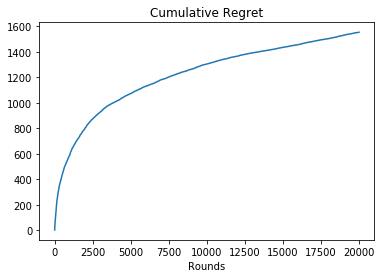

In [5]:
plt.plot(np.cumsum(regret))
plt.title("Cumulative Regret")
plt.xlabel("Rounds")

Text(0.5,0,'Rounds')

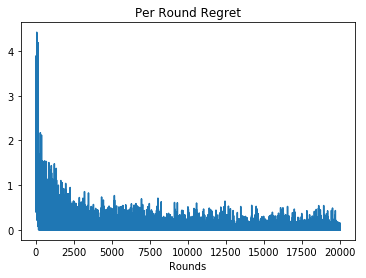

In [6]:
plt.plot(regret)
plt.title("Per Round Regret")
plt.xlabel("Rounds")

In [7]:
mu

array([[0.13784582, 0.1389532 , 0.06906012, 0.72569021, 0.0957135 ,
        0.71728845, 0.95120928, 0.0925657 , 0.17805213, 0.90347914],
       [0.33635837, 0.11227248, 0.73476214, 0.83337318, 0.51735335,
        0.3692722 , 0.4046016 , 0.90402775, 0.90432013, 0.43238033],
       [0.50264282, 0.02685157, 0.97987454, 0.54025649, 0.50932804,
        0.28451414, 0.58046748, 0.58083742, 0.60215841, 0.6509633 ],
       [0.51650757, 0.20720992, 0.8423182 , 0.48997993, 0.00132178,
        0.5134511 , 0.92830939, 0.02998565, 0.70246079, 0.61162725],
       [0.6595654 , 0.67573565, 0.44553091, 0.38265843, 0.79812157,
        0.97797696, 0.320534  , 0.34596389, 0.93314498, 0.98320709],
       [0.68372029, 0.38269296, 0.84679152, 0.84152424, 0.77613381,
        0.14613224, 0.80414935, 0.19212929, 0.8536449 , 0.05238004],
       [0.95346233, 0.7496519 , 0.61555775, 0.1245667 , 0.65602971,
        0.44878703, 0.55354124, 0.31496455, 0.92138975, 0.75151019],
       [0.15460112, 0.84009226, 0.3820745

In [8]:
mu_bar

array([[0.14529915, 0.15748032, 0.10752688, 0.71548999, 0.07954545,
        0.72993534, 0.94742119, 0.09574468, 0.19811321, 0.90247364],
       [0.30701754, 0.08333333, 0.72798949, 0.83218884, 0.51908397,
        0.29411765, 0.421875  , 0.90475688, 0.90584029, 0.30973451],
       [0.44419643, 0.01388889, 0.97970869, 0.54110613, 0.50380711,
        0.21374046, 0.59631728, 0.59873867, 0.58099878, 0.66315205],
       [0.49323308, 0.26035503, 0.83945171, 0.49877751, 0.01666667,
        0.51066856, 0.92695325, 0.04477612, 0.67946578, 0.6124197 ],
       [0.65705128, 0.6215781 , 0.47715736, 0.35714286, 0.80102041,
        0.97560976, 0.25352113, 0.36283186, 0.93337889, 0.98185353],
       [0.64817518, 0.40104167, 0.84240688, 0.84535005, 0.7782466 ,
        0.15873016, 0.79005021, 0.2125    , 0.8479798 , 0.14814814],
       [0.95395869, 0.75476191, 0.58148148, 0.11764706, 0.65820106,
        0.49027237, 0.51578948, 0.30188679, 0.92240588, 0.7649919 ],
       [0.15819209, 0.84171005, 0.3922805

In [9]:
mu - mu_bar

array([[-0.00745333, -0.01852712, -0.03846676,  0.01020022,  0.01616804,
        -0.01264689,  0.0037881 , -0.00317898, -0.02006108,  0.0010055 ],
       [ 0.02934083,  0.02893915,  0.00677265,  0.00118434, -0.00173062,
         0.07515455, -0.01727341, -0.00072913, -0.00152016,  0.12264582],
       [ 0.0584464 ,  0.01296268,  0.00016585, -0.00084964,  0.00552093,
         0.07077368, -0.0158498 , -0.01790125,  0.02115963, -0.01218875],
       [ 0.02327448, -0.05314511,  0.00286649, -0.00879758, -0.01534488,
         0.00278254,  0.00135614, -0.01479047,  0.02299501, -0.00079245],
       [ 0.00251412,  0.05415755, -0.03162645,  0.02551558, -0.00289884,
         0.0023672 ,  0.06701287, -0.01686797, -0.00023391,  0.00135356],
       [ 0.0355451 , -0.0183487 ,  0.00438465, -0.00382581, -0.00211279,
        -0.01259793,  0.01409914, -0.02037071,  0.00566511, -0.09576811],
       [-0.00049636, -0.00511001,  0.03407627,  0.00691964, -0.00217135,
        -0.04148534,  0.03775176,  0.01307776

In [10]:
T_ka

array([[ 117.00000021,  126.99999979,   93.        , 2846.99999763,
          88.        , 2629.00000109, 8976.99999975,   94.00000026,
         106.        , 4932.00000126],
       [ 114.00000108,   59.99999959, 1521.99999945, 4659.99999991,
         393.0000017 ,  119.        ,  191.99999962, 9480.99999633,
        3356.00000199,  113.00000032],
       [ 448.00000058,   72.0000005 , 9955.00000032, 1337.99999859,
         787.9999989 ,  131.        , 2117.99999932, 2536.99999967,
         821.00000278, 1801.99999933],
       [ 665.00000083,  169.        , 6346.99999819,  817.999997  ,
          60.        ,  702.9999999 , 9049.00000169,   67.00000008,
        1198.00000024,  934.00000206],
       [ 624.00000036,  620.99999941,  196.99999975,  112.        ,
        2352.00000093, 8363.99999937,   71.        ,  113.00000005,
        2927.000002  , 4628.99999814],
       [ 685.00000128,  191.99999812, 5932.99999835, 6699.00000108,
        2132.99999977,   62.9999984 , 2191.00000239,   80